# [IAPR][iapr]: Lab 3 ‒  Classification


**Group ID:** 45

**Author 1 (sciper):** Elias William (367106)  
**Author 2 (sciper):** Erik Kvikne (360962)   
**Author 3 (sciper):** Sami Laubo (360965)  

**Release date:** 19.04.2023  
**Due date:** 05.05.2023 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

--
## 0. Setup

In [1]:
%load_ext autoreload
%autoreload 2

In this lab, we will use PyTorch. If you are not familiar with this library, [here](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html) is a quick tutorial of the basics.

In [2]:
import platform
print(platform.system())
if platform.system() == "Darwin":
    %pip install torch==1.8.1 torchvision==0.9.1
else:
    %pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html

Windows
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement torch==1.8.1+cu111 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu113, 1.11.0+cu115, 1.12.0, 1.12.0+cpu, 1.12.0+cu113, 1.12.0+cu116, 1.12.1, 1.12.1+cpu, 1.12.1+cu113, 1.12.1+cu116, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 2.0.0, 2.0.0+cpu, 2.0.0+cu117, 2.0.0+cu118)
ERROR: No matching distribution found for torch==1.8.1+cu111


In [3]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1 - Out-of-Distribution detection in colorectal cancer histology (12 points)

Colorectal cancer is one of the most widespread cancers for men and women. Diagnosis complemented with prognostic and predictive biomarker information is essential for patient monitoring and applying personalized treatments. A critical marker is the tumor/stroma ratio in unhealthy tissues sampled from the colon. The higher the ratio, the more invasive the cancer is. The degree of invasion is tightly linked to patient survial probability.

To measure the ratio, a pathologist needs to analyze the unhealthy tissue under a microscope and estimate it from a look. As the number of samples to analyze is huge and estimations are only sometimes precise, automatic recognition of the different tissue types in histological images has become essential. Such an automatic process requires the development of a multi-class classifier to identify the numerous tissues. As shown below, they are usually 8 tissue types to categorize: TUMOR, STROMA, LYMPHO (lymphocytes), MUCOSA, COMPLEX (complex stroma), DEBRIS, ADIPOSE and EMPTY (background).

<br />
<br />
<figure>
    <img src="../data/lab-03-data/part1/kather16.svg" width="1100">
    <center>
    <figcaption>Fig1: Collection of tissue types in colorectal cancer histology (Kather-16)</figcaption>
    </center>
</figure>
<br />
<br />


Up to this day, state-of-the-art methods use deep-learning-based supervised learning methods. A downfall of such an approach is the necessity to access a well-annotated training dataset. In histology, annotating data is difficult. It is time-consuming and requires the expertise of pathologists. Moreover, the annotator must label every tissue type while only two (TUMOR and STROMA) are interesting. 


Consequently, we propose another approach. In order to make the annotation task less tedious, we ask the annotator to label only the tissues of interest and dump the others. Then, we must train a binary classifier to automatically recognize these tissues at test time. In this part, you will implement the proposed approach.

### 1.1 Binary classifier with Mahalanobis distance (3 points)

Based on the abovementioned process, your task is to build a model that recognizes TUMOR (Label 0) and STROMA (Label 1) tissue types. Your model will be supervised by a training dataset containing TUMOR and STROMA annotations; note that all other tissues have been dropped.
We will not ask you to train a deep-learning-based binary classifier from scratch. Instead, we provide excellent features (descriptors) of the images we extracted from a visual foundation model. (Note: As the nature of the foundation model is not part of this lecture, feel free to ask TAs if you are curious).

Run the cell below to extract the provided train and test dataset. Each image is represented by a 768-d feature vector extracted from a visual foundation model. The train and test datasets contain feature vectors of 878 and 186 images respectively.

In [4]:
import torch 

# Label mapping
label_to_classname = {0 : "TUMOR", 1 : "STROMA"}

# Train features and labels
train_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_features.pth"))
train_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_labels.pth"))

# Test features and labels
test_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_features.pth"))
test_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_labels.pth"))

test_features.shape

torch.Size([186, 768])

**Task 1 (2.5 points)** Based on the training features (```train_features```) and training labels (```train_labels```), classify the test features (```test_features```) using minimum Mahalanobis distance.

*Note:* You are not allowed to use any prebuilt Mahalanobis distance function. Additionally, ```torch.cov``` is not defined to compute the covariance matrix. You can use ```sklearn.covariance.LedoitWolf``` instead.

In [5]:
### Task 1
from sklearn.covariance import LedoitWolf
import numpy as np

def Mahalanobis_classify(train_features, train_labels, test_features):
    # Compute means
    mean_zero = torch.mean(train_features[train_labels == 0], 0).numpy()
    mean_ones = torch.mean(train_features[train_labels == 1], 0).numpy()

    # Compute covariance matrices
    covariance_zero = LedoitWolf().fit(train_features[train_labels == 0]).covariance_
    covariance_ones = LedoitWolf().fit(train_features[train_labels == 1]).covariance_

    covariance_zero_inv = np.linalg.inv(covariance_zero)
    covariance_ones_inv = np.linalg.inv(covariance_ones)
    
    # Predicted classes
    pred = np.zeros(test_features.shape[0], dtype=np.int8)

    # Compute distance and choose min dist as class
    for idx, x in enumerate(test_features.numpy()):
        delta = x - mean_zero
        dist_zero = np.sqrt(delta @ covariance_zero_inv @ delta.T)

        delta = x - mean_ones
        dist_ones = np.sqrt(delta @ covariance_ones_inv @ delta.T)

        if dist_ones < dist_zero:
            pred[idx] = 1

    return pred

**Task 2 (0.5 points)** Compute the accuracy of your predictions with the test labels (```test_labels```).

In [6]:
### Task 2

test_pred = Mahalanobis_classify(train_features, train_labels, test_features)
accuracy = np.round(100*(test_labels == test_pred).sum() / test_labels.shape[0],2)
print(f'{accuracy= } %')

accuracy= 97.85 %


### 1.2 Out-of-Distribution detection with Mahalanobis distance (3 points)

You will note that the test you run above is not really realistic. Like the training set, it contains only the TUMOR and STROMA tissue types. Nevertheless, at test time, the other tissues (Label -1) are also present and cannot be filtered by hand. Moreover, they cannot be recognized by the model as they are out of the training distribution (It is the consequence of the laziness of the annotators ;)). For this reason, it is essential to filter them out. This task is called Out-of-Distribution (OoD) detection. 

A simple way to do OoD detection is to compute for every test example an OoD-ness score which should be low for In-Distribution (ID) examples and high for OoDs. Then we define a threshold from which every example with an OoD-ness lying above is discarded, and those lying below are forwarded to the model for prediction. An example of OoD-ness score is the minimum Mahalanobis distance.

Run the cell below to load a new test set containing OoD examples. It has 186 ID and 558 OoD examples.

In [7]:
label_to_classname_w_ood = {0 : "TUMOR", 1 : "STROMA", -1 : "OoD"}

# Test features and labels with OoD tissues
test_features_w_ood = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test2_features.pth"))
test_labels_w_ood = torch.load(os.path.join(data_base_path, data_folder,"part1/k16_test2_labels.pth"))

test_features_w_ood.shape

torch.Size([744, 768])

**Task 1 (0.5 point)** Why do you think the minimum Mahalanobis distance is a good OoD-ness score?

**Answer:**

The Mahalanobis distance gives the distance from a point to a distribution. A large covariance leads to a smaller distance, which is intuitive because a large variance in the distribution makes it more likely for a point far away to be a part of the distribution. The minimum Mahalanobis distance takes the smallest distance to any distribution, and if this distance is larger than the threshold we know that the distance to any distribution is larger than our threshold. We can then discard this point as being a part of any distribution if it is above the threshold, saying it's OoD.

**Task 2 (0.5 point)** Compute the minimum Mahalanobis distance for every test examples in ```test_features_w_ood``` with respect to the training features (```train_features```).

In [8]:
### Task 2
def Mahalanobis_dist(train_features, train_labels, test_features):
    # Compute means
    mean_zero = torch.mean(train_features[train_labels == 0], 0).numpy()
    mean_ones = torch.mean(train_features[train_labels == 1], 0).numpy()

    # Compute covariance matrices
    covariance_zero = LedoitWolf().fit(train_features[train_labels == 0]).covariance_
    covariance_ones = LedoitWolf().fit(train_features[train_labels == 1]).covariance_

    covariance_zero_inv = np.linalg.inv(covariance_zero)
    covariance_ones_inv = np.linalg.inv(covariance_ones)
    
    # Predicted classes
    Mahal_dist = np.zeros(test_features.shape[0])

    # Compute distance and choose min dist as class
    for idx, x in enumerate(test_features.numpy()):
        delta = x - mean_zero
        dist_zero = np.sqrt(delta @ covariance_zero_inv @ delta.T)

        delta = x - mean_ones
        dist_ones = np.sqrt(delta @ covariance_ones_inv @ delta.T)

        Mahal_dist[idx] = np.min([dist_zero, dist_ones])

    return Mahal_dist

**Task 3 (0.5 point)** Plot a histogram to show the difference between the Mahalanobis distance of TUMOR, STROMA and OoD tissue types and comment on what you observe.

C:\Users\Elias\AppData\Local\Temp\ipykernel_15596\2215486585.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 2, (3,4))
C:\Users\Elias\AppData\Local\Temp\ipykernel_15596\2215486585.py:23: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


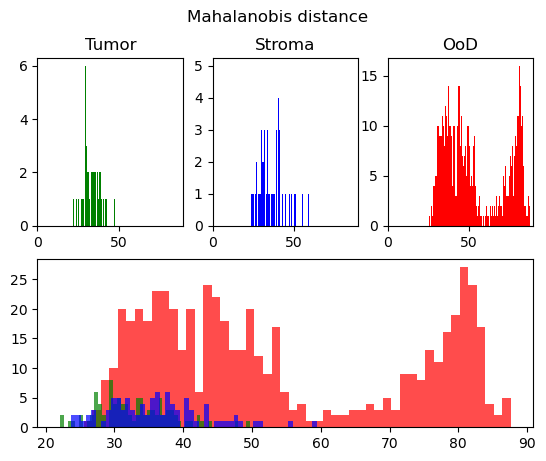

In [9]:
### Task 3
import matplotlib.pyplot as plt

dists = Mahalanobis_dist(train_features, train_labels, test_features_w_ood)

fig, axs = plt.subplots(2, 3)
axs[0, 0].hist(dists[test_labels_w_ood ==  0], bins=100, color='g')
axs[0, 1].hist(dists[test_labels_w_ood ==  1], bins=100, color='b')
axs[0, 2].hist(dists[test_labels_w_ood == -1], bins=100, color='r')
axs[0, 0].set_title('Tumor')
axs[0, 1].set_title('Stroma')
axs[0, 2].set_title('OoD')
axs[0, 0].set_xlim([0, 90])
axs[0, 1].set_xlim([0, 90])
axs[0, 2].set_xlim([0, 90])

ax = plt.subplot(2, 2, (3,4))
ax.hist(dists[test_labels_w_ood == -1], bins=50, color='r', alpha=.7)
ax.hist(dists[test_labels_w_ood ==  0], bins=50, color='g', alpha=.7)
ax.hist(dists[test_labels_w_ood ==  1], bins=50, color='b', alpha=.7)

plt.suptitle('Mahalanobis distance')
plt.tight_layout()
plt.show()

**Observations:** We can see that the amount of OoD samples are way more than the actual stroma/tumor samples. Also there is alot of OoD samples that has the same distance to the distributions as the stroma/tumor, this means that it will be hard to classify in distributon to out of distribution with this distance measure. 

**Task 4 (1 point)** Find a threshold on the Mahalanobis distance such that 95% of the OoD examples are filtered out. How much TUMOR and STROMA have also been filtered out?

In [10]:
### Task 4
### YOUR CODE

# Find threshold by bisection method
def find_thres(dists):
    upper_lim = np.max(dists)
    lower_lim = np.min(dists)
    thres = (upper_lim + lower_lim)/2
    # Goal percentage
    perc_goal = 0.95
    # Acceptable percentage error
    gamma = 0.001
    # Percentage of dists that is cut out
    dists_thres = dists[dists >= thres]
    perc_cut_out =  dists_thres.size / dists.size

    max_iter = 200
    it = 1
    # Adjust thres until goal is met
    while( np.abs(perc_cut_out - perc_goal) >= gamma or it < max_iter ):

        if perc_cut_out < perc_goal:
            # Lower threshold if not enough samples has been thresholded
            upper_lim = thres
        else:
            # Higher threshold
            lower_lim = thres

        thres = (upper_lim + lower_lim)/2
        # Percentage of dists that is cut out
        dists_thres = dists[dists >= thres]
        perc_cut_out =  dists_thres.size / dists.size
        it += it

    return thres

In [11]:
# Get all out of distribution samples distances in the test set
dist_ood = dists[test_labels_w_ood == -1]
# Find the distance threshold that excludes 95 % of them
thres = find_thres(dist_ood)

print(f'Threshold distance: {round(thres,2)}')

# Get all in distribution sample distances
dist_iod = dists[test_labels_w_ood != -1]
# Apply the calculated threshold
dist_iod_thres = dist_iod[ dist_iod <= thres ]

# Calculate the percentage of the in distribution samples removed
perc_iod_del = 1 - dist_iod_thres.size / dist_iod.size

print(f'Percentage of iod samples removed: {round(100*perc_iod_del,2)} %')


Threshold distance: 30.74
Percentage of iod samples removed: 67.74 %


**Task 5 (0.5 point)** Assign prediction -1 to filtered out examples and compute the average class-wise accuracy of your prediction with test labels (```test_labels_w_ood```). Is it satisfactory?

In [12]:
### Task 5
### YOUR CODE

# Get the mask for the predicted in distribution samples
mask_ood = dists > thres
# Predict on the entire test set and label the OoD samples -1
pred = Mahalanobis_classify(train_features, train_labels, test_features_w_ood)
pred[mask_ood] = -1

accuracy = (test_labels_w_ood == pred).sum() / test_labels_w_ood.shape[0]
print(f'Mahalanobis Accuracy with out of distribution samples: {round(100*accuracy,2)} %')


Mahalanobis Accuracy with out of distribution samples: 79.3 %


About 80% accuracy. It is not as bad as we thought but many of the tumor/stroma points we know are misclassifed already because of the threshold. So the relatively high accuracy comes from all the OoD samples being correctly classified. If you look at the histograms above we also see that there are many more OoD samples than Tomur/stroma. Which means that these will bias the accuracy to be reltively good.

### 1.3 Out-of-distribution detection with k-NN classifier (6 points)

The visual foundation models are known to be very good k-NN classifiers. It motivates us to implement a k-NN classifier to recognize TUMOR and STROMA. Moreover, k-NN distance is a good OoD-ness score and suits our task.

**Task 1 (2 points)** Based on the training features (```train_features```) and training labels (```train_labels```), classify the test features (```test_features```) using a k-NN classifier. Then report the accuracy of your predictions with the test labels (```test_labels```).

*Note:* The choice of `k` is up to you.

In [13]:
### Task 1
### YOUR CODE

# K-Nearest neighbours algorithm
def knn(train_features, train_labels, test_features, K = 5):
    # Train_features (N,D)
    # Train_labels (N,)
    # Test_features (Nt,D)

    test_preds = torch.zeros(test_features.shape[0])
    
    # List of k smallest distances
    dist_min = []

    for idx, test_feature in enumerate(test_features):
        # Compute distance from test samples to all training samples
        delta_features = train_features - test_feature
        distances = torch.sqrt(torch.sum(delta_features**2, axis=1))

        # Find the K nearest neighbours of this test sample
        idx_min_dist = torch.zeros(K)

        for i in range(K):
            # Find nearest neighbour
            idx_min = torch.argmin(distances)
            idx_min_dist[i] = idx_min
            # Remove this neighbour from the list, this is a little dumb but
            # We need to keep the indecis of the list
            distances[idx_min] += 1000

        # Get labels for these indecise and vote for the most common one
        idx_min_dist = idx_min_dist.numpy().astype(int)
        near_labels = train_labels[idx_min_dist]

        counts = np.bincount(near_labels)
        most_common_label = np.argmax(counts)
        test_preds[idx] = most_common_label

        # Add the k smallest distances to list
        dist_min.append(np.array([distances[i]-1000 for i in idx_min_dist])) 

    return test_preds.numpy(), np.array(dist_min)


In [14]:
test_preds,_ = knn(train_features, train_labels, test_features)

In [15]:
### Task 2
### YOUR CODE
print(f'Accuracy of k-NN: {round(100 * np.sum(test_preds == test_labels)/test_preds.shape[0],2)} %')

Accuracy of k-NN: 99.46 %


**Task 2 (2 points)** Perform OoD detection on the test features (```test_features_w_ood```) using a k-NN distance based OoD-ness score. Find a threshold on your OoD-ness score such that 95% of the OoD examples are filtered out. How much TUMOR and STROMA have also been filtered out? Finally, assign prediction -1 to filter out examples and compute the average class-wise accuracy of your prediction with test labels (```test_labels_w_ood```).

*Note:* The OoD-ness is based on the distance to the k-nearest neighbors. The formulation is up to you. You have to justify your choice.

In [16]:
### Task 2
### YOUR CODE

# Out of distribution K-nearest neighbours
def oodknn():
    # Find distance of the knn
    test_preds_w_odd, dist_w_ood = knn(train_features, train_labels, test_features_w_ood, K = 3)

    # Sum the knn distance of ood
    dist_sum_ood = np.sum(dist_w_ood[test_labels_w_ood==-1], axis = 1)

    # Find threshold
    thres = find_thres(dist_sum_ood)
    
    print()
    print(f'Threshold of OoD-ness score (sum of k-NN distance): {round(thres,2)}')

    # Get distance of iods
    dist_sum_iod = np.sum(dist_w_ood[test_labels_w_ood != -1], axis=1)
    # Iods within the threshold
    dist_iod_thres = dist_sum_iod[ dist_sum_iod <= thres ]
    # Amount of iod that was removed
    perc_iod_del = 1 - dist_iod_thres.size / dist_sum_iod.size
    
    print()
    print(f'Percentage of iod samples removed: {round(100*perc_iod_del,2)} %')

    dist_sum_all = np.sum(dist_w_ood, axis = 1)
    mask_ood = dist_sum_all > thres
    test_preds_w_odd[mask_ood] = -1

    print(f'Accuracy of out of distribution knn: {round(100*(test_labels_w_ood == test_preds_w_odd).sum() / test_labels_w_ood.shape[0],2)} %')

oodknn()


Threshold of OoD-ness score (sum of k-NN distance): 127.97

Percentage of iod samples removed: 56.99 %
Accuracy of out of distribution knn: 81.99 %


**Task 3 (1 point)** Is k-NN better than Mahalanobis distance ? Make an hypothesis for the reasons.

**Answer:** k-NN removed 56.99 % of the iod samples, while Mahalonobis distance removed 67.7 %. Since these 95 % of the OoD examples were filtered out in both cases, k-NN seems to be better than Mahalonobis distance. The mahalanobis distance takes all the training samples into account and creates mean and variance. The Knn is a more local approach where only closeby samples in the training set determines the predicted label. The Knn performes better on our dataset. This can be attributed to that knn has a hyperparameter to play with which makes it more flexible. You can optimize for the number of neighbours in the algorithm. Also if there are intraclass variance in featurespace, making the mean and variance might not be a good idea. Lets say that it is very hard to tell if one should label a test sample as in distribution or out of it. Then a more local approach like Knn might be better than the more global approach of mahalanobis.

**Task 4 (1 point)** Do you think we can suggest the approach presented in this exercise to compute TUMOR/STROMA ratio automatically ? Justify your thoughs. If not, suggest at least two ideas to improve it.

*Note:* Annotating all the training dataset is not an option.

**Answer:** No, we remove way to many in distribution examples. Detection of cancer is also a very sensetive task due to the consecuences of for example missing cancer in a patient. So that we remove so many of the in distribution samples is not good. A better approach might be to not filter out as many out of distribution examples and instedd pick out candidates from the algorithm that a medical doctor can look at. This will atleast save him/her alot of time.
Improvement ideas:
1. If the data is not easily divisable in feature space, you are in for trouble. A better embedding, or feature extractor neural network for the images could make it easier to separate the classes. So a more advanced or sofisticated neural network would be good or techniques such as data augmentation etc.
2. Try out different distance measures for KNN. Now the euklidean distances is used but this might not necessarily be the best to remove out of distribution samples or predict on the test set.

---

## Part 2 (12 points)
In this part, we aim to classify cervical cells resulting from Pap smear tests. To that end we'll be using a publicly available cell dataset: Sipakmed (https://www.cs.uoi.gr/~marina/sipakmed.html). The dataset is composed of 4049 images of isolated cells cropped from 966 cluster cell images of Pap smear slides. Each cell in the dataset has been categorized in either of the following categories: 

    - Superficial-Intermediate.
    - Parabasal.
    - Koilocytotic.
    - Dysketarotic.
    - Metaplastic.
Your objective is to implement a classifier to automate the cell classification process. To ease your work we provide you with pre-computed embeddings for each images (`lab-03-data/part2/sipakmed_clean_embeddings.pth`). The embeddings are obtained from a pre-trained ResNet-50 (https://arxiv.org/pdf/1512.03385.pdf) and the corresponding images are also provided (`lab-03-data/part2/sipakmed_clean`). Note that you are free to discard the provided embeddings and work directy with the images.

### 2.1 Dataset (4 points)
Your first task is prepare the dataset such that it can be used to train your model. For that purpose we prepared the skeleton of the class `Sipakmed` that inherits from the class `Dataset` of PyTorch. Read the documentation (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) and complete the missing parts.

In [17]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import os
from torch import nn
from collections import OrderedDict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math

# Use GPU device if available
# Accompanied by .to(device) later to store data on correct advice
if torch.cuda.is_available():
    device = torch.device('cuda')
    CUDA = True
else:
    device = torch.device('cpu')
    CUDA = False
print(f'{device = }')

device = device(type='cpu')


In [18]:
# Load the features
features_path = '../data/lab-03-data/part2/sipakmed_clean_embeddings.pth'

In [19]:
class Sipakmed(Dataset):
    phase_dict = {
            'train': {'start': 0.0, 'stop': 0.5},
            'val': {'start': 0.5, 'stop': 0.75},
            'test': {'start': 0.75, 'stop': 1.0}
    }
    label_dict = {
        'im_Superficial-Intermediate': 0,
        'im_Parabasal': 1, 
        'im_Metaplastic': 2,
        'im_Koilocytotic': 3,
        'im_Dyskeratotic': 4
    }
    
    def __init__(self, features_path, phase):

        super(Sipakmed, self).__init__()
        # Store class attributes
        self.phase = phase
        
        # Collect the dataimport torch
        import torch.nn.functional as F
        import numpy as np
        self.raw_data = torch.load(features_path)
        self.features, self.labels, self.paths = self.collect_data()
        
    def collect_data(self):
        # Iterate over the dirs/classes
        features, labels, paths = [], [], []
        for dir_name, dir_dict in self.raw_data.items():
            # Get the paths and embeddings
            dir_paths, dir_embeddings = list(zip(*[(k, v) for k, v in dir_dict.items()]))
            
            # Split
            n = len(dir_paths)
            np.random.seed(42)
            permutations = np.random.permutation(n)
            dir_paths = np.array(dir_paths)[permutations]
            dir_embeddings = torch.stack(dir_embeddings)[permutations]
            n_start = int(n * self.phase_dict[self.phase]['start'])
            n_stop = int(n * self.phase_dict[self.phase]['stop'])
            dir_embeddings = dir_embeddings[n_start: n_stop]
            dir_paths = dir_paths[n_start: n_stop]
    
            # Store
            features.append(dir_embeddings)
            paths.append(dir_paths)
            dir_labels = torch.tensor([self.label_dict[p.split('/')[-2]] for p in dir_paths])
            labels.append(dir_labels)
            
        # Merge
        features = torch.cat(features)
        labels = torch.cat(labels)
        paths = np.concatenate(paths)
        return features, labels, paths
            
        
    def __len__(self,):
        """
        Returns the number of samples in the dataset.
        """
        ### YOUR CODE
        return self.labels.shape[0]
    
    def __getitem__(self, index):
        """
        Returns the embedding, label, and image path of queried index.
        """
        ### YOUR CODE
        # return embedding, label, path
        return self.features[index], self.labels[index], self.paths[index]

Once the implementation of `Sipakmed` completed, create 3 instances of the class (train/val/test) with the corresponding `phase` flag.

In [20]:
# Instantiate the datasets
train_dataset = Sipakmed(features_path, 'train')
val_dataset = Sipakmed(features_path, 'val')
test_dataset = Sipakmed(features_path, 'test')

Now that your datasets are ready, use the class `DataLoader` from PyTorch to let it handle efficiently the batching, shuffling, etc. of your data.

In [21]:
# Instantiate the data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=CUDA, num_workers=CUDA)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=True, pin_memory=CUDA, num_workers=CUDA)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=True, pin_memory=CUDA, num_workers=CUDA)

Get to know your data. Plot a few example images for each class of your dataset.

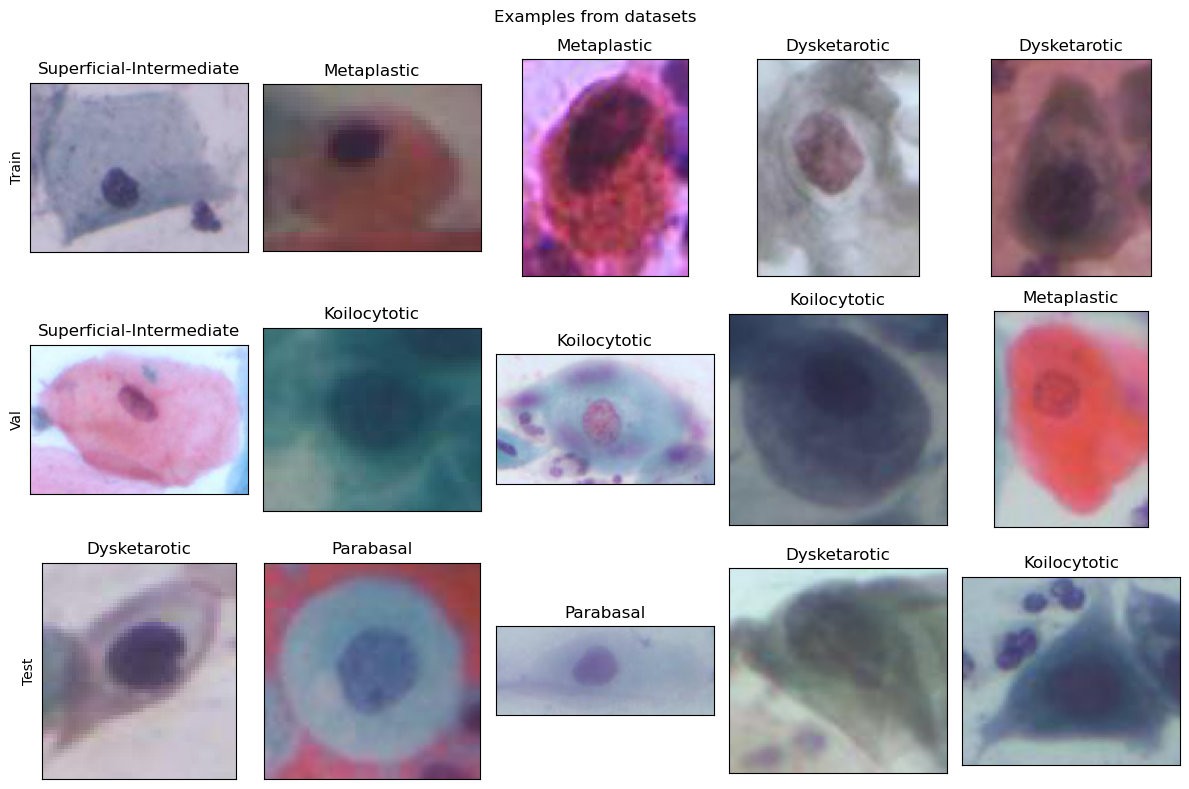

In [22]:
# Visualize some training example
label_to_class = ['Superficial-Intermediate', 'Parabasal', 'Koilocytotic', 'Dysketarotic', 'Metaplastic']

import matplotlib.image as mpimg
fig, axs = plt.subplots(3, 5, figsize=(12, 8))

for y, (dataloader, title) in enumerate(zip([train_loader, val_loader, test_loader], ['Train', 'Val', 'Test'])):
    _, labels, paths = next(iter(dataloader))
    axs[y, 0].set_ylabel(title)

    for x in range(5):
        img = mpimg.imread('../data/lab-03-data/part2/' + paths[x])
        axs[y, x].imshow(img)
        axs[y, x].set_title(label_to_class[labels[x]])
        axs[y, x].set_xticks([])
        axs[y, x].set_yticks([])

plt.suptitle('Examples from datasets')
plt.tight_layout()
plt.show()

### 2.2 Training (4 points)
In this part your objective is to implement the required tools to train your model. The first thing you'll need is a a model which takes as input the pre-computed features and returns the corresponding class probabilities/logits.

In [23]:
# Implement the model
from torch import optim
import torch.nn.functional as F

# Simple dense neural net
embedding_dim = train_dataset.features.shape[1]
output_dim = 5
model = nn.Sequential( 
    nn.Linear(embedding_dim, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, output_dim)
).to(device) # Send to cuda or cpu device
print(model)

Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=5, bias=True)
)


The optimizer will keep track of your model's parameters, gradients, etc (https://pytorch.org/docs/stable/optim.html). It is responsible to update your model's parameters after each forward pass using the backpropagation algorithm.

In [24]:
# Set the optimizer
# Adam optimizer with learning rate 0.0001
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [25]:
# Set the loss
# Cross entropy loss
criterion = nn.CrossEntropyLoss()

Implement a function that takes as input the model's output and the corresponding labels and returns the perçentage of correct predictions.

In [26]:
def accuracy(outputs, labels):
    """
    Computes the accuracy of predictions based on the model outputs (NxK: N samples, K classes) 
    and the labels (N: N samples).
    """
    return (outputs.argmax(axis=1) == labels).sum() / len(labels)

Implement a funtion `train` that forwards the complete training set through your model (= 1 epoch) and updates its parameters after each forward pass. To keep track of the training process make sure to at least return the accuracy of the model and the average loss it incurred through the current epoch.

In [27]:
def train(model, optimizer, criterion, loader):
    # Set the model in train mode
    model.train()
    
    # Iterate over the batches
    full_outputs = []
    full_labels = []
    losses = []
    for batch in loader:
        # Get the embeddings, labels and paths 
        embeddings, labels, paths = batch
        
        # For each sample in batch
        output = model(embeddings)

        # Compute cross entropy loss
        loss = criterion(output, labels)
        
        # Reset the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        # Store the outputs, labels and loss
        full_outputs.append(output)
        losses.append(loss)
            
        full_labels.append(labels)
    
    # Concat
    full_outputs = torch.cat(full_outputs).cpu()
    full_labels = torch.cat(full_labels).cpu()
    losses = torch.stack(losses).mean().cpu()
    
    # Compute the accuracy
    acc = accuracy(full_outputs, full_labels)
    return acc, full_outputs, full_labels, losses

Implement a funtion `validate` that forwards the complete validation or test set through your model and evaluates its predictions. To keep track of the training process make sure to at least return the accuracy of the model and the average loss it incurred through the current epoch.

In [28]:
@torch.no_grad()
def validate(model, criterion, loader):
    # Set the model in train mode (prob should be validation mode?)
    model.eval()
    
    # Iterate over the batches
    full_outputs = []
    full_labels = []
    full_paths = []
    losses = []
    for batch in loader:
        # Get the embeddings, labels and paths 
        embeddings, labels, paths = batch
        
        # Feed the embeddings to the model
        output = model(embeddings)

        # Compute cross entropy loss
        loss = criterion(output, labels)
        
        # Store the outputs, labels and loss
        full_outputs.append(output)
        full_labels.append(labels)
        losses.append(loss)
        full_paths.append(paths)
    
    # Concat
    full_outputs = torch.cat(full_outputs).cpu()
    full_labels = torch.cat(full_labels).cpu()
    losses = torch.stack(losses).mean().cpu()
    full_paths = np.concatenate(full_paths)
    
    # Compute the accuracy
    acc = accuracy(full_outputs, full_labels)
    return acc, full_outputs, full_labels, losses, full_paths

You should now be able to train you model. Alternate between training and validation steps to find and save the best model (best accuracy on the validation set).

In [29]:
# Main loop
epochs = 15
best_acc = 0
model_savepath = '../data/lab-03/model_pytorch.ckpt'

for epoch in range(epochs):
    # Train
    acc_train, _, _, losses = train(model, optimizer, criterion, train_loader)

    # Evaluate
    acc_val, _, _, _, _ = validate(model, criterion, val_loader)
    
    print(f'Epoch {epoch} - Train acc: {acc_train:.4f}  Validation acc: {acc_val:.4f}')

    # Save the model
    if acc_val > best_acc:
        torch.save(model.state_dict(), model_savepath)

Epoch 0 - Train acc: 0.7146  Validation acc: 0.8538
Epoch 1 - Train acc: 0.8932  Validation acc: 0.8943
Epoch 2 - Train acc: 0.9407  Validation acc: 0.9249
Epoch 3 - Train acc: 0.9585  Validation acc: 0.9279
Epoch 4 - Train acc: 0.9723  Validation acc: 0.9348
Epoch 5 - Train acc: 0.9817  Validation acc: 0.9437
Epoch 6 - Train acc: 0.9866  Validation acc: 0.9387
Epoch 7 - Train acc: 0.9901  Validation acc: 0.9407
Epoch 8 - Train acc: 0.9921  Validation acc: 0.9377
Epoch 9 - Train acc: 0.9921  Validation acc: 0.9417
Epoch 10 - Train acc: 0.9955  Validation acc: 0.9437
Epoch 11 - Train acc: 0.9980  Validation acc: 0.9417
Epoch 12 - Train acc: 1.0000  Validation acc: 0.9427
Epoch 13 - Train acc: 0.9995  Validation acc: 0.9437
Epoch 14 - Train acc: 1.0000  Validation acc: 0.9447


### 2.3 Evaluation (4 points)
Re-load the best model and evaluate its predictions on the test set.

In [30]:
# Re-load the best model
checkpoint = torch.load(model_savepath)
model.load_state_dict(checkpoint)
model.eval()

# Get data
test_features, test_labels, test_paths = test_dataset.collect_data()

# Evaluate
model_outputs = model(test_features)
loss = criterion(model_outputs, test_labels)
acc = accuracy(model_outputs, test_labels)

print(f'Test set - Accuracy: {acc:.4f}, Loss: {loss:.4f}')

Test set - Accuracy: 0.9458, Loss: 0.1849


A useful tool to analyze your model's performance on the different classes is the confusion matrix (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). Computes its entries for your model and the test set.

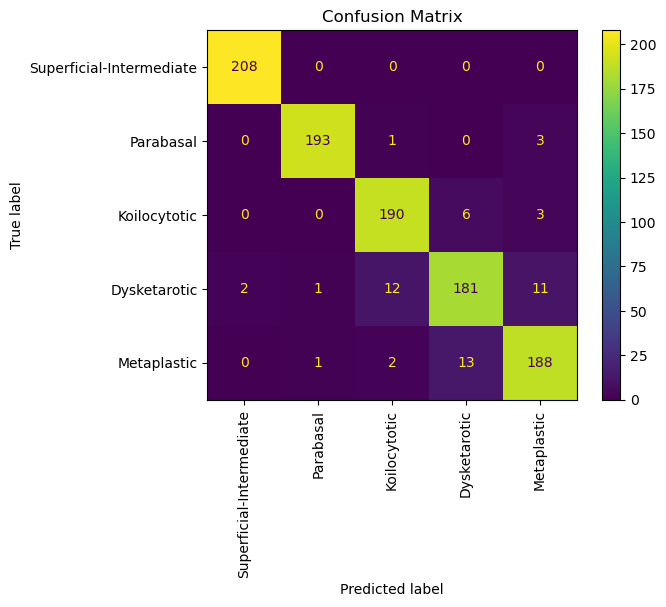

In [31]:
# Display the confusion matrix
model_pred = model_outputs.argmax(axis=1)
cm = confusion_matrix(test_labels, model_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=label_to_class)

disp.plot()
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()

Alternatively it can be useful to plot the problematic samples as well as the predicted and ground truth classes. Can you do so?

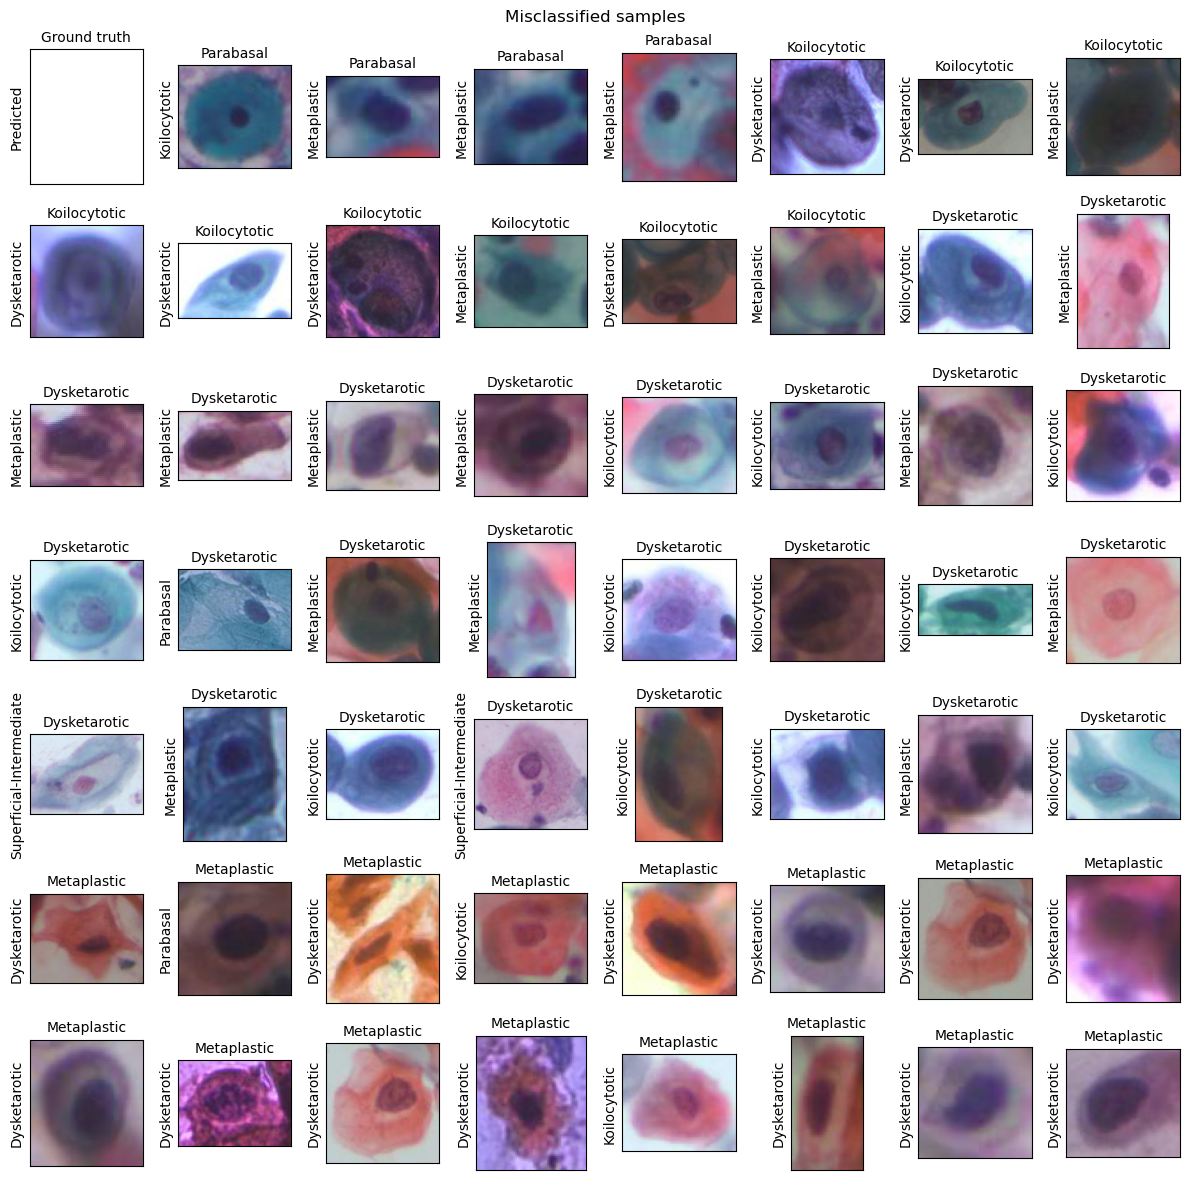

In [32]:
# Find the misclassified samples
mis_indexes = np.where(test_labels != model_pred)[0]

# Plot the misclassified samples
fig, axs = plt.subplots(7, 8, figsize=(12, 12))
axs = axs.ravel()

axs[0].set_title('Ground truth', fontsize=10)
axs[0].set_ylabel('Predicted', fontsize=10)
axs[0].set_xticks([])
axs[0].set_yticks([])

for fig_idx, mis_idx in enumerate(mis_indexes):
    # Get sample image
    img = mpimg.imread('../data/lab-03-data/part2/' + test_paths[mis_idx])

    # Get labels
    mis_label = label_to_class[model_pred[mis_idx]]
    gt_label = label_to_class[test_labels[mis_idx]]

    axs[fig_idx+1].imshow(img)
    axs[fig_idx+1].set_title(gt_label, fontsize=10)
    axs[fig_idx+1].set_ylabel(mis_label, fontsize=10)
    axs[fig_idx+1].set_xticks([])
    axs[fig_idx+1].set_yticks([])

plt.suptitle('Misclassified samples')
plt.tight_layout()
plt.show()